# This notebook makes all Python Plots in Paper (Figures 1,5-8,12-19)

In [1]:

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import QuadratureGrid, LinearGrid,ConcentricGrid
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from desc.compute._core import dot # on obj branch must be desc.compute.compute_funs
%matplotlib inline
plt.rcParams.update({'figure.figsize': (8,6)})
plt.rcParams.update({'font.size': 22})
xfontsize=18

DESC version 0.4.13+144.g24501b1, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 24.25 GB available memory


# Make F FSA v rho plots (Figures 1,7,12,13,14) 

In [2]:
def get_F_FSA(descfile,is_eq=False,use_p_FSA=False):
    '''is_eq is for if the file you give is only an Equilibrium, not an EquilibriaFamily
    use_p_FSA is for if you want to divide by p_FSA instead of p_vol_avg (results in larger normalized error near edge and axis due to grad(p) -> 0 at axis and edge)
    
    '''
    filepath = descfile
    if is_eq:
        eq=Equilibrium.load(load_from=filepath)
    else:
        eq = EquilibriaFamily.load(load_from=filepath)[-1]
    print('Getting p vol avg')
    # get p vol avg
    if eq.N == 0:
        qgrid = QuadratureGrid(L=eq.L_grid,M=eq.M_grid,N=1,NFP=1)
    else:
        qgrid = QuadratureGrid(L=eq.L_grid,M=eq.M_grid,N=eq.N_grid,NFP=eq.NFP)
    g = eq.compute(name='sqrt(g)',grid=qgrid)['sqrt(g)'] # get jacobian
    
    p_r = eq.compute(name='p_r',grid=qgrid)['p_r']
    eRho = eq.compute(name='e^rho',grid=qgrid)['e^rho']
    eRho_mag = np.sqrt(dot(eRho,eRho))
    V = np.sum(qgrid.weights * np.abs(g)) # volume
    p_V_avg = np.sum(qgrid.weights * np.abs(p_r)*eRho_mag * np.abs(g)) / V
    
    
    print('Getting F')
    if eq.N == 0:
        qgrid = LinearGrid(L=5*eq.L,M=5*eq.M,N=1,NFP=1,axis=False) 
    else:
        qgrid = LinearGrid(L=5*eq.L,M=2*eq.M,N=2*eq.N,NFP=eq.NFP,axis=False) 
        g = eq.compute(name='sqrt(g)',grid=qgrid)['sqrt(g)'].reshape((qgrid.M,qgrid.L,qgrid.N),order='F') # get jacobian
    eRho = eq.compute(name='e^rho',grid=qgrid)['e^rho']
    eRho_mag = np.sqrt(dot(eRho,eRho))
    F = eq.compute(name='|F|',grid=qgrid)['|F|']


    rho = np.unique(qgrid.nodes[:,0])
    theta = np.unique(qgrid.nodes[:,1])
    zeta = np.unique(qgrid.nodes[:,2])
    
    # Flux Surface Averaged Force versus rho
    np.shape(F.reshape((qgrid.M,qgrid.L,qgrid.N),order='F'))
    F_mag = F.reshape((qgrid.M,qgrid.L,qgrid.N),order='F')

    F_rhos_fsa = np.trapz(x=theta,y=np.trapz(x=zeta,y=F_mag*np.abs(g),axis=-1),axis=0) / np.trapz(x=theta,y=np.trapz(x=zeta,y=np.abs(g),axis=-1),axis=0)

    if use_p_FSA:
        p_r = eq.compute(name='p_r',grid=qgrid)['p_r']
        p_grad = np.abs(p_r)*eRho_mag
        p_grad = p_grad.reshape((qgrid.M,qgrid.L,qgrid.N),order='F')
        p_rhos_fsa = np.trapz(x=theta,y=np.trapz(x=zeta,y=np.abs(p_grad*g),axis=-1),axis=0) / np.trapz(x=theta,y=np.trapz(x=zeta,y=np.abs(g),axis=-1),axis=0)

        return F_rhos_fsa/p_rhos_fsa , rho
    else:
        return F_rhos_fsa/p_V_avg, rho


## VMEC Force FSA vs rho NS scan

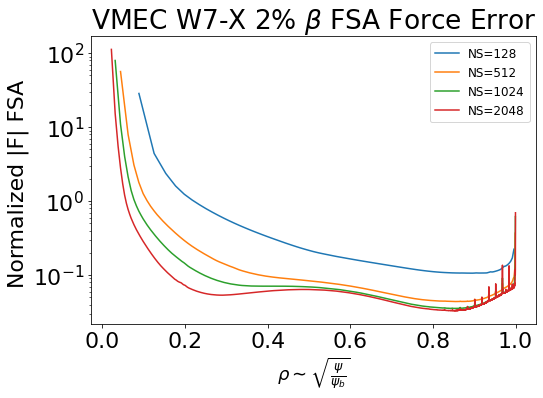

In [3]:
# compare FSA for different ns of VMEC with finite diff 2nd order with lambda on full mesh 
plt.figure()
radial_ind=0
for curr_s in [128,512,1024,2048]:
    fsa_filename = f'VMEC_outputs//s{curr_s}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt' # rmove full lambda for half lambda
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,curr_s)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],label=f'NS={curr_s}')

plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'VMEC W7-X 2% $\beta$ FSA Force Error')
plt.tight_layout()

plt.legend(fontsize=12)
plt.savefig('Figures/W7X_VMEC_FSA_ns_conv.pdf', bbox_inches='tight',pad_inches = 0.1)

## VMEC Force FSA vs rho MN scan

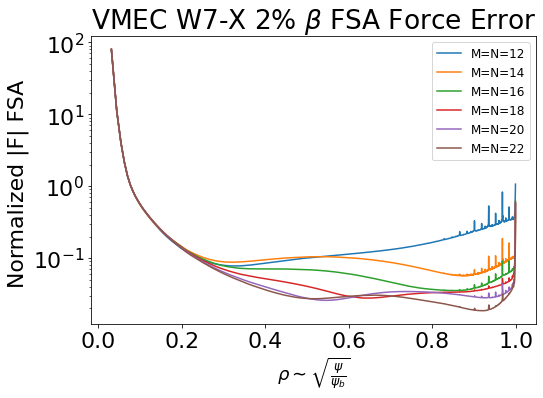

In [4]:
# compare FSA for different ns of VMEC with finite diff 2nd order with lambda on full mesh 
plt.figure()
radial_ind=0
for MN in np.arange(12,23,2):
    fsa_filename = f'VMEC_outputs//MN{MN}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt' # rmove full lambda for half lambda
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],label=f'M=N={MN}')

plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'VMEC W7-X 2% $\beta$ FSA Force Error')
plt.tight_layout()

plt.legend(fontsize=12)
# plt.savefig('Figures/W7X_VMEC_FSA_MN_conv.pdf',format='pdf')
plt.savefig('Figures/W7X_VMEC_FSA_MN_conv.pdf', bbox_inches='tight',pad_inches = 0.1)

## VMEC Force FSA v rho Radial Derivative Method Scan

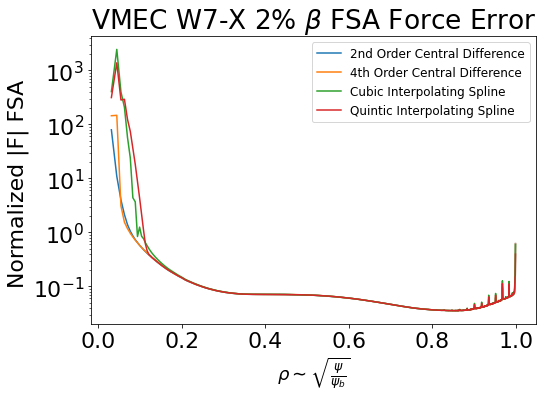

In [5]:

plt.figure()
radial_ind=0
labels=['2nd Order Central Difference','4th Order Central Difference', 'Cubic Interpolating Spline','Quintic Interpolating Spline']
for i,method in enumerate(['finite difference','finite difference 4th', 'spline','spapi']):
    fsa_filename = f'VMEC_outputs//{method}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_full_lam.txt' # rmove full lambda for half lambda
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],label=labels[i])

plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'VMEC W7-X 2% $\beta$ FSA Force Error')
plt.tight_layout()

plt.legend(fontsize=12)
# plt.savefig('Figures/W7X_VMEC_FSA_deriv_methods.pdf',format='pdf')
plt.savefig('Figures/W7X_VMEC_FSA_deriv_methods.pdf', bbox_inches='tight',pad_inches = 0.1)

## VMEC F FSA v Rho FTOL Scan

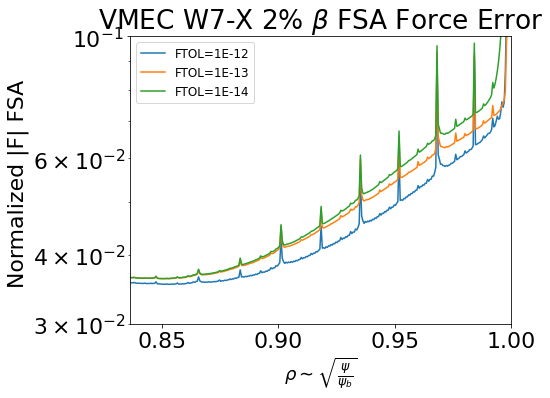

In [6]:
# compare FSA for different ns of VMEC with finite diff 2nd order with lambda on full mesh 

plt.figure(figsize=(8,6))
radial_ind=0
for ftol in np.arange(12,15,1):
    fsa_filename = f'VMEC_outputs//ftol{ftol}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt'
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],label=f'FTOL=1E-{ftol}')

plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'VMEC W7-X 2% $\beta$ FSA Force Error')
plt.xlim([np.sqrt(0.7),1])
plt.ylim([3e-2,1e-1])
plt.tight_layout()


plt.legend(fontsize=12)
# plt.savefig('Figures/W7X_VMEC_FSA_ftol_conv.pdf',format='pdf')
plt.savefig('Figures/W7X_VMEC_FSA_ftol_conv.pdf', bbox_inches='tight',pad_inches = 0.1)

## DESC Force FSA vs rho M=N Scan

Getting p vol avg
Getting F
Getting p vol avg
Getting F
Getting p vol avg
Getting F
Getting p vol avg
Getting F
Getting p vol avg
Getting F


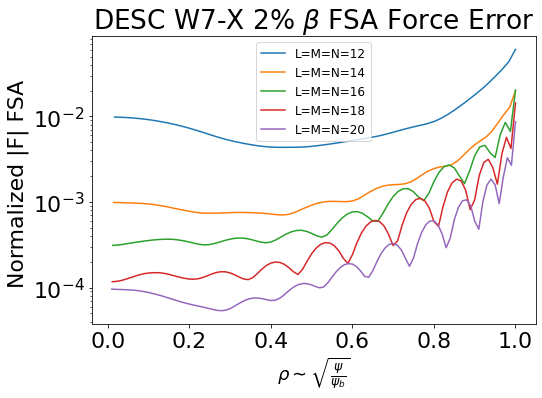

In [7]:
plt.figure()
for MN in [12,14,16,18,20]:
    if MN <= 16:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_f2_compute_branch_output.h5'
    elif MN==18:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_compute_branch_full//W7X_M{MN}_N{MN}_ansi_cpu1_64GB_output.h5'
    elif MN==20:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2//W7X_M{MN}_N{MN}_ansi_cpu1_warm_pert_output.h5'

    else:
        eqfname=f'DESC_outputs//W7X_M{MN}_N{MN}_ansi_cpu1_output.h5'
    eq = EquilibriaFamily.load(load_from=eqfname)

    DESCF_FSA,rho=get_F_FSA(eqfname,use_p_FSA=False)
    plt.semilogy(rho[:],DESCF_FSA[:],label=f'L=M=N={MN}')

plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')



plt.title(r'DESC W7-X 2% $\beta$ FSA Force Error')
plt.tight_layout()

plt.legend(fontsize=12)
# plt.savefig('Figures/W7X_DESC_FSA_MN_conv.pdf',format='pdf')
plt.savefig('Figures/W7X_DESC_FSA_MN_conv.pdf', bbox_inches='tight',pad_inches = 0.1)


## VMEC and DESC F FSA v Rho Plot

Getting p vol avg
Getting F
Getting p vol avg
Getting F
Getting p vol avg
Getting F


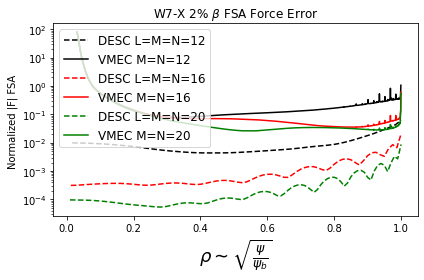

In [8]:

%matplotlib inline
plt.close('all')
plt.figure()
colors = ['k','r','g']
DESC_dats={}

for i,MN in enumerate([12,16,20]):
    if MN <= 16:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_f2_compute_branch_output.h5'
    elif MN==18:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_pert_compute_branch_output.h5'
    elif MN==20:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2//W7X_M{MN}_N{MN}_ansi_cpu1_warm_pert_output.h5'
    eq = EquilibriaFamily.load(load_from=eqfname)
    DESCF_FSA,rho=get_F_FSA(eqfname,use_p_FSA=False)
    DESC_dats[eqfname]=DESCF_FSA,rho
    plt.semilogy(rho[:],DESCF_FSA[:],colors[i]+'--',label=f'DESC L=M=N={MN}')
    
    fsa_filename = f'VMEC_outputs//MN{MN}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt' 
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],colors[i]+'-',label=f'VMEC M=N={MN}')
plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'W7-X 2% $\beta$ FSA Force Error')
plt.tight_layout()

plt.legend(fontsize=12)


# plt.savefig('Figures/W7X_VMEC_DESC_FSA.pdf',format='pdf')
# plt.savefig('Figures/W7X_VMEC_DESC_FSA.pdf', bbox_inches='tight',pad_inches = 0.1)





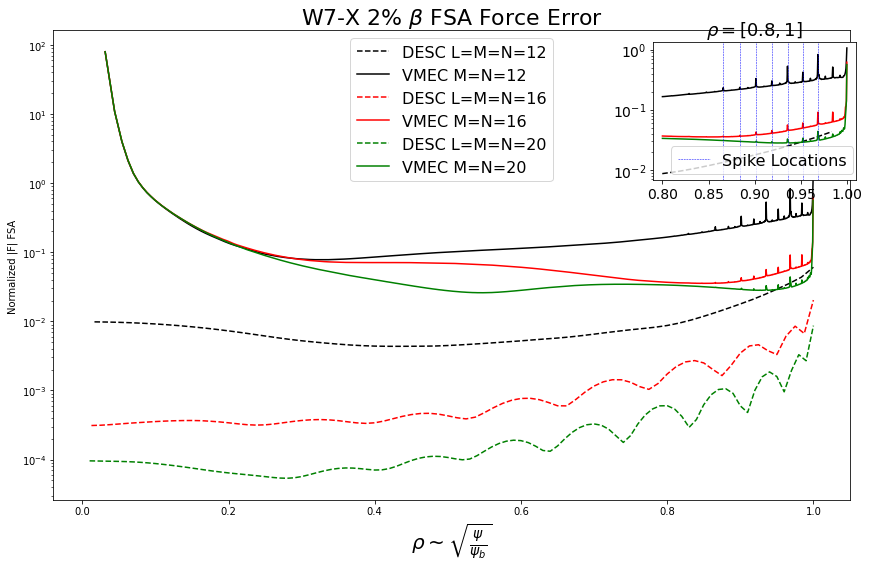

In [9]:
# Add plot insert showing the spike locations
plt.close('all')
plt.figure(figsize=(12,8))
colors = ['k','r','g']

for i,MN in enumerate([12,16,20]):
    if MN <= 16:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_f2_compute_branch_output.h5'
    elif MN==18:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_pert_compute_branch_output.h5'
    elif MN==20:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2//W7X_M{MN}_N{MN}_ansi_cpu1_warm_pert_output.h5'
    DESCF_FSA,rho=DESC_dats[eqfname]

    plt.semilogy(rho[:],DESCF_FSA[:],colors[i]+'--',label=f'DESC L=M=N={MN}')
    
    fsa_filename = f'VMEC_outputs//MN{MN}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt' 
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    plt.semilogy(rho[radial_ind:-1],data_FSA[radial_ind:-1],colors[i]+'-',label=f'VMEC M=N={MN}')
plt.xlabel(r'$\rho \sim \sqrt{\frac{\psi}{\psi_b}}$',fontsize=xfontsize+2)
plt.ylabel('Normalized |F| FSA ')
plt.title(r'W7-X 2% $\beta$ FSA Force Error',fontsize=22)
plt.tight_layout()

plt.legend(loc='upper center',fontsize=16)

a = plt.axes([.76, .68, .235, .24])#, facecolor='y')

force_peak_s_locations = np.asarray([0.7498,0.781,0.8123,0.8436,0.8749,0.9062,0.9374])


for i,MN in enumerate([12,16,20]):
    if MN <= 16:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_f2_compute_branch_output.h5'
    elif MN==18:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2_compute_branch//W7X_M{MN}_N{MN}_ansi_cpu1_pert_compute_branch_output.h5'
    elif MN==20:
        eqfname=f'DESC_outputs//M{MN}_N{MN}_ansi_cpu1_f2//W7X_M{MN}_N{MN}_ansi_cpu1_warm_pert_output.h5'
    DESCF_FSA,rho=DESC_dats[eqfname]
    rhoind1 = np.where(np.abs(rho-0.8) == np.min(np.abs(rho-0.8)))[0][0]
    rhoind2 = np.where(np.abs(rho-1) == np.min(np.abs(rho-1)))[0][0]
    if MN==12:
        plt.semilogy(rho[rhoind1:rhoind2],DESCF_FSA[rhoind1:rhoind2],colors[i]+'--')
    
    fsa_filename = f'VMEC_outputs//MN{MN}_VMEC_W7X_F_FSA_normalized_by_p_V_avg_findif_full_lam.txt' 
    data_FSA = np.genfromtxt(fsa_filename,dtype=float)
    s = np.linspace(0,1,1024)
    rho = np.sqrt(s) # convert s to rho
    rhoind1 = np.where(np.abs(rho-0.8) == np.min(np.abs(rho-0.8)))[0][0]
    rhoind2 = np.where(np.abs(rho-1) == np.min(np.abs(rho-1)))[0][0]
    plt.semilogy(rho[rhoind1:rhoind2],data_FSA[rhoind1:rhoind2],colors[i]+'-')

plt.xticks(fontsize=14)    
    
plt.yticks(fontsize=14)
plt.axvline(x=np.sqrt(force_peak_s_locations[0]),c='b',linestyle='--',label='Spike Locations',linewidth=0.5)
for s in force_peak_s_locations[1:]:
    plt.axvline(x=np.sqrt(s),c='b',linestyle='--',linewidth=0.5)
plt.legend(loc='upper left',fontsize=16,bbox_to_anchor=(0.05,0.3))
plt.title(r'$\rho = [0.8,1]$',fontsize=18)
plt.savefig('Figures/W7X_VMEC DESC_FSA_with_blowup.pdf', bbox_inches='tight',pad_inches = 0.1)

# F vs time plot (Figure 8)

## gather DESC timing and force error data from output files

In [10]:
# define functions

def get_timing_data(timing_file):
    '''
    
    Parameters
    ----------
    timing_file : string
        Absolute path to a DESC stdout log output file.

    Returns
    -------
    total_time: float
        runtime in seconds

    '''
    with open(timing_file) as f:
        lines = f.readlines()
        for line in lines:
            if line.find("Total time") != -1:
                line = line.split('=')# split into the ['Total Time', 'XXX min'] part
                break
        t_line = line[-1].strip().split(' ') #split last part into ['XXX','min']
        t = t_line[0]
        if t_line[1].find('sec') != -1:
            total_time = float(t.strip()) # get time in seconds
        if t_line[1] == 'min':
            total_time = float(t.strip())*60 # get time in seconds
        elif t_line[1] == 'hrs':
            total_time = float(t.strip())*3600 # get time in seconds
    return total_time

def get_f_err(dirname,filepath):
    '''  run DESC to calculate the force error mean weighted by volume
    input: 
        dirname: directory name: string, name of direcctory housing DESC output
    filepath: string, path to output .h5 file containing DESC output, to be used to calcualte average force
    output:
        average force error, normalized by volume, and the total plasma energy'''
     # run DESC and get the force 
    print(filepath)
    eq = EquilibriaFamily.load(load_from=filepath)[-1]
    qgrid = QuadratureGrid(L=eq.L,M=eq.M,N=eq.N,NFP=eq.NFP)
    g = eq.compute(name='sqrt(g)',grid=qgrid)['sqrt(g)'] # get jacobian
    eRho = eq.compute(name='e^rho',grid=qgrid)['e^rho']
    eRho_mag = np.sqrt(dot(eRho,eRho))
    F = eq.compute(name='|F|',grid=qgrid)['|F|']
    V = np.sum(qgrid.weights * np.abs(g)) # volume
    F_V_avg = np.sum(qgrid.weights * F * np.abs(g)) / V
    p_r = eq.compute(name='p_r',grid=qgrid)['p_r']
    p_V_avg = np.sum(qgrid.weights * np.abs(p_r)*eRho_mag * np.abs(g)) / V
    F_normalized = F_V_avg / p_V_avg
    E = eq.compute(name='W')

    return F_normalized,E


In [11]:
import pickle as p
# %pdb
# lowres
data_dict = {}

cwd = os.getcwd()
cwd = cwd + '/DESC_outputs/lowres_compute_branch'
for diret in os.walk(cwd):
    files = diret[2]
    timing_file_exists = False
    print('here')
    for filename in files:
        if filename.find("compute_branch_output") != -1: # check if output file is present
            try:
                timing_file_exists = True
    # only needed if have files in directories
                dirname = diret[0].split('\\')[-1].strip()
                log_path = os.path.join(diret[0],'log_W7X_%s.out'%dirname)

                filepath = os.path.join(diret[0],filename)
                filename = filename.strip("_output.h5")
                log_path = glob.glob(diret[0]+'/slurm*.out')[0]
                filename = filename.split('_')
                M = filename[1].strip('M')
                N = M
                zern_pattern = filename[3]
                diff_ftol = False
                print(len(filename))

                cpu = filename[4].strip('cpu')                      
                #input_file = glob.glob(diret[0]+'/input*')[0]
                F,E = get_f_err(diret[0],filepath)
                t = get_timing_data(log_path)

                data_dict['M%s_N%s_%s_cpu%s'%(M,N,zern_pattern,cpu)] = [t,F]
                data_dict['E_M%s_N%s_%s_cpu%s'%(M,N,zern_pattern,cpu)] = E
                
                # time in seconds, F as a decimal of (F_V_avg / gradP_V_avg)
            except Exception as e:
                print(e)
                continue
        #if timing_file_exists:
            print(M,N,zern_pattern,t,F)
with open('DESC_outputs/DESC_W7X_pressure_F_times_normalized_volume_avg_compute_branch_lowres.p','wb') as f:
    p.dump(data_dict,f)

here
here
7
/home/dpanici/DESC/paper_figs/DESC_outputs/lowres_compute_branch/M14_N14_ansi_cpu1_compute_branch/W7X_M14_N14_ansi_cpu1_compute_branch_output.h5
14 14 ansi 10368.0 0.002976251941909225
here
7
/home/dpanici/DESC/paper_figs/DESC_outputs/lowres_compute_branch/M8_N8_fringe_cpu1_compute_branch/W7X_M8_N8_fringe_cpu1_compute_branch_output.h5
8 8 fringe 598.8000000000001 0.06072838527006247
here
7
/home/dpanici/DESC/paper_figs/DESC_outputs/lowres_compute_branch/M14_N14_fringe_cpu1_compute_branch/W7X_M14_N14_fringe_cpu1_compute_branch_output.h5
14 14 fringe 17280.0 0.003350115473865638
here
7
/home/dpanici/DESC/paper_figs/DESC_outputs/lowres_compute_branch/M12_N12_fringe_cpu1_compute_branch/W7X_M12_N12_fringe_cpu1_compute_branch_output.h5
12 12 fringe 9936.0 0.012194768520399815
here
7
/home/dpanici/DESC/paper_figs/DESC_outputs/lowres_compute_branch/M12_N12_ansi_cpu1_compute_branch/W7X_M12_N12_ansi_cpu1_compute_branch_output.h5
12 12 ansi 2472.0 0.013293831150314786
here
7
/home/dpa

In [12]:
#%pdb
data_dict = {}

cwd = os.getcwd()
cwd = cwd + '\DESC_outputs'

for diret in os.walk(cwd):
    files = diret[2]
    timing_file_exists = False

    for filename in files:
        if filename.find("compute_branch_output") != -1 and diret[0].find('lowres')==-1: # check if output file is present
            try:
                timing_file_exists = True
    # only needed if have files in directories
                dirname = diret[0].split('\\')[-1].strip()
                log_path = os.path.join(diret[0],'log_W7X_%s.out'%dirname)

                filepath = os.path.join(diret[0],filename)
                filename = filename.strip("_output.h5")
                log_path = glob.glob(diret[0]+'/slurm*.out')[0]
                filename = filename.split('_')
                M = filename[1].strip('M')
                N = M
                zern_pattern = filename[3]
                diff_ftol = False
                print(len(filename))
                    
                cpu = filename[4].strip('cpu')                      
                #input_file = glob.glob(diret[0]+'/input*')[0]
                F,E = get_f_err(diret[0],filepath)
                t = get_timing_data(log_path)
                
                data_dict['M%s_N%s_%s_cpu%s'%(M,N,zern_pattern,cpu)] = [t,F]
                data_dict['E_M%s_N%s_%s_cpu%s'%(M,N,zern_pattern,cpu)] = E
                
                # time in seconds, F as a decimal of (F_V_avg / gradP_V_avg)
            except Exception as e:
                print(e)
                continue
        #if timing_file_exists:
            print(M,N,zern_pattern,t,F)


In [13]:
# save as a pickle file
with open('DESC_outputs/DESC_W7X_pressure_F_times_normalized_volume_avg_compute_branch.p','wb') as f:
    p.dump(data_dict,f)

## plot F v t (Figure 8)

dict_keys([])
KeyError('s128_M8_N8_f13_cpu1')
KeyError('s256_M8_N8_f13_cpu1')
KeyError('s512_M8_N8_f13_cpu1')
KeyError('s1024_M8_N8_f13_cpu1')
KeyError('s128_M8_N8_f14_cpu1')
KeyError('s256_M8_N8_f14_cpu1')
KeyError('s512_M8_N8_f14_cpu1')
KeyError('s1024_M8_N8_f14_cpu1')
KeyError('s128_M8_N8_f15_cpu1')
KeyError('s256_M8_N8_f15_cpu1')
KeyError('s512_M8_N8_f15_cpu1')
KeyError('s1024_M8_N8_f15_cpu1')
KeyError('s128_M8_N8_f16_cpu1')
KeyError('s256_M8_N8_f16_cpu1')
KeyError('s512_M8_N8_f16_cpu1')
KeyError('s1024_M8_N8_f16_cpu1')
KeyError('s128_M8_N8_f17_cpu1')
KeyError('s256_M8_N8_f17_cpu1')
KeyError('s512_M8_N8_f17_cpu1')
KeyError('s1024_M8_N8_f17_cpu1')
KeyError('s128_M8_N8_f18_cpu1')
KeyError('s256_M8_N8_f18_cpu1')
KeyError('s512_M8_N8_f18_cpu1')
KeyError('s1024_M8_N8_f18_cpu1')
KeyError('s128_M10_N10_f13_cpu1')
KeyError('s256_M10_N10_f13_cpu1')
KeyError('s512_M10_N10_f13_cpu1')
KeyError('s1024_M10_N10_f13_cpu1')
KeyError('s128_M10_N10_f14_cpu1')
KeyError('s256_M10_N10_f14_cpu1')
KeyErro

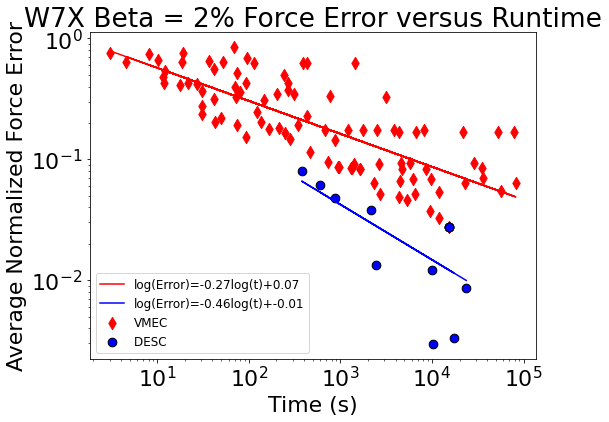

In [15]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

plt.close("all")


# below has ftols 4,8,12 and 13-18

with open("VMEC_outputs/W7X_timing_F_findif_normalized_01_099s_lam_full_mesh.txt.p", "rb") as f:
    data = pickle.load(f)

with open(
    "DESC_outputs/DESC_W7X_pressure_F_times_normalized_volume_avg_compute_branch.p", "rb"
) as ff:
    desc_data = pickle.load(ff)

print(desc_data.keys())

xfontsize = 18
legend = 12
plt.rcParams.update({"figure.figsize": (8, 6)})
plt.rcParams.update({"font.size": 22})


desc_patterns = ["fringe", "ansi"]

MNs = [8, 10, 12, 14, 16, 18]
ftols = [4, 8, 12]
ns = [128, 256, 512, 1024]

########################## Simplified F v t plot ################### 

tot_Fs_VMEC = []
tot_ts_VMEC = []

desc_patterns = ["fringe", "ansi"]


cpus = [1, 2, 4, 8]
MNs = [8, 10, 12, 14, 16, 18, 20, 22]
# not sure if higher MNs actually do anything
ftols = list(np.arange(13, 19)) + [4, 8, 12]
ns = [128, 256, 512, 1024]
cpus = [1]

for fi, cpu in enumerate(cpus):
    plt.figure(fi + 4)
    ts = [[], [], [], []]
    Fs = [[], [], [], []]
    ts2 = [[], [], [], []]
    Fs2 = [[], [], [], []]
    MN_for_colors = [[], [], [], []]
    MN_for_colors2 = [[], [], [], []]
    for MN in MNs:

        for j, ftol in enumerate(ftols):

            for i, s in enumerate(ns):
                runname = "s%s_M%s_N%s_f%s_cpu%s" % (s, MN, MN, ftol, cpu)
                try:
                    t, F = data[runname]

                    if (
                        F < 100
                    ):  # only include runs with error less than 20% across volume
                        ts[i].append(t)
                        Fs[i].append(F)
                        MN_for_colors[i].append(MN)
                except Exception as e:

                    print(repr(e))
                    # print('VMEC run with params %s does not exist'%runname)
    tot_ts = [t for slist in ts for t in slist]
    tot_Fs = [t for slist in Fs for t in slist]
    plt.scatter(tot_ts, np.asarray(tot_Fs), c="r", marker="d", label="VMEC", s=75)

    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Average Normalized Force Error")
    plt.title("W7X Beta = 2" + "%" + " Force Error versus Runtime")
    ax = plt.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")
    # plt.xlim([3.5e-1,6e4])

tot_Fs_VMEC = tot_Fs
tot_ts_VMEC = tot_ts

# same for DESC


for fi, cpu in enumerate(cpus):
    plt.figure(fi + 4)
    ts = [[], []]  # one list for each pattern
    Fs = [[], []]
    MN_for_colors = [[], []]
    for MN in MNs:

        for i, pat in enumerate(desc_patterns):
            runname = "M%s_N%s_%s_cpu%s" % (MN, MN, pat, cpu)
            try:
                if MN <= 18:
                    t, F = desc_data[runname]
                elif MN == 18:
                    # t,F = desc_data_highres[runname]
                    pass

                if F < 100:
                    ts[i].append(t)
                    Fs[i].append(np.abs(F))
                    MN_for_colors[i].append(MN)

            except:
                print("DESC run with params %s does not exist" % runname)

    tot_ts = [t for slist in ts for t in slist]
    tot_Fs = [t for slist in Fs for t in slist]
    plt.scatter(
        tot_ts,
        np.asarray(tot_Fs),
        c="b",
        marker="o",
        label="DESC ",
        edgecolors="k",
        s=75,
        linewidths=1,
    )
    plt.legend()


tot_Fs_DESC = tot_Fs
tot_ts_DESC = tot_ts


#################### lowres DESC runs #######################
### lower resolution DESC data
with open(
    "DESC_outputs/DESC_W7X_pressure_F_times_normalized_volume_avg_compute_branch_lowres.p", "rb"
) as ff:
    desc_data = pickle.load(ff)

desc_patterns = ["fringe", "ansi"]

include_lowres_DESC = True
if include_lowres_DESC:
    for fi, cpu in enumerate(cpus):
        plt.figure(4)
        ts = [[], []]  # one list for each pattern I guess
        Fs = [[], []]
        MN_for_colors = [[], []]
        for MN in MNs:

            for i, pat in enumerate(desc_patterns):
                runname = "M%s_N%s_%s_cpu%s" % (MN, MN, pat, cpu)
                try:
                    t, F = desc_data[runname]
                    # if F < 1e-5:
                    #     F = F /( 4*np.pi * 1e-7)
                    ts[i].append(t)
                    Fs[i].append(np.abs(F))
                    MN_for_colors[i].append(MN)

                except:
                    #print("DESC run with params %s does not exist" % runname)
                    pass
        tot_ts = [t for slist in ts for t in slist]
        tot_Fs = [t for slist in Fs for t in slist]
        plt.scatter(
            tot_ts,
            np.asarray(tot_Fs),
            c="b",
            marker="o",
            edgecolors="k",
            s=75,
            linewidths=1,
        )
        plt.legend()

tot_Fs_DESC.extend(tot_Fs)
tot_ts_DESC.extend(tot_ts)


### make trendlines for F vs time

vmec_x = np.asarray(tot_ts_VMEC)
vmec_y = np.asarray(tot_Fs_VMEC)
import scipy.stats

vmec_log_x = np.log(np.asarray(vmec_x))
vmec_log_y = np.log(np.asarray(vmec_y))
fit = scipy.stats.linregress(x=vmec_log_x, y=vmec_log_y)
slope = fit.slope

plt.plot(
    vmec_x,
    vmec_x ** slope * np.exp(fit.intercept),
    "r-",
    label=f"log(Error)={slope:1.2f}log(t)+{fit.intercept:1.2f}",
)

desc_x = np.asarray(tot_ts_DESC)
desc_y = np.asarray(tot_Fs_DESC)

desc_log_x = np.log(np.asarray(desc_x))
desc_log_y = np.log(np.asarray(desc_y))
fit_desc = scipy.stats.linregress(x=desc_log_x, y=desc_log_y)
slope_desc = fit_desc.slope

plt.plot(
    desc_x,
    desc_x ** slope_desc * np.exp(fit_desc.intercept),
    "b-",
    label=f"log(Error)={slope_desc:1.2f}log(t)+{fit_desc.intercept:1.2f}",
)

plt.legend(fontsize=legend)
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

plt.savefig("Figures/DESC_VMEC_F_t_comp.pdf", bbox_inches="tight", pad_inches=0.1)



# Force Error Convergence Plots (Figures 5,6)

## DESC (Figure 6)

In [16]:
from desc.equilibrium import EquilibriaFamily
from desc.plotting import plot_surfaces, plot_section, plot_comparison
from desc.vmec import VMECIO
from desc.equilibrium import EquilibriaFamily
from desc.grid import QuadratureGrid
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from desc.compute._core import dot
%matplotlib inline
import pickle as p
plt.rcParams.update({"figure.figsize": (8, 6)})
plt.rcParams.update({"font.size": 22})
xfontsize = 18

In [17]:
def get_f_err(eq):
    '''  run DESC to calculate the force error mean weighted by volume'''
     # run DESC and get the force 

    qgrid = QuadratureGrid(L=eq.L,M=eq.M,N=eq.N,NFP=eq.NFP)
    g = eq.compute(name='sqrt(g)',grid=qgrid)['sqrt(g)'] # get jacobian
    eRho = eq.compute(name='e^rho',grid=qgrid)['e^rho']
    eRho_mag = np.sqrt(dot(eRho,eRho))
    F = eq.compute(name='|F|',grid=qgrid)['|F|']
    V = np.sum(qgrid.weights * np.abs(g)) # volume
    F_V_avg = np.sum(qgrid.weights * F * np.abs(g)) / V
    p_r = eq.compute(name='p_r',grid=qgrid)['p_r']
    p_V_avg = np.sum(qgrid.weights * np.abs(p_r)*eRho_mag * np.abs(g)) / V
    F_normalized = F_V_avg / p_V_avg
    E = eq.compute(name='W')

    return F_normalized,E

/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_spacing' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute 'shift' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute 'rotmat' was not loaded.
  warnings.warn(


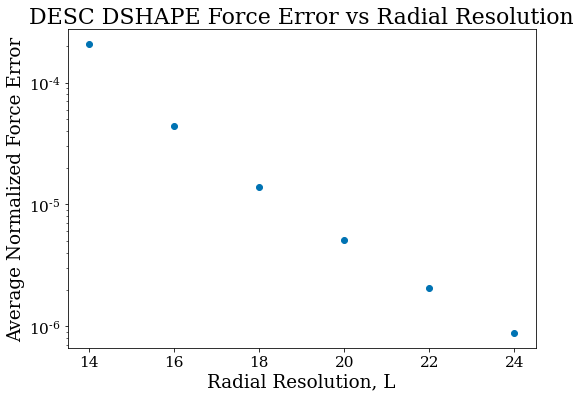

In [18]:
eqfQ = EquilibriaFamily.load(load_from="DESC_outputs/DSHAPE_L_ansi_output.h5")

Fns_Q = []

Es_Q = []


for eqq in eqfQ:
    F_n, E = get_f_err(eqq)
    Es_Q.append(E)
    Fns_Q.append(F_n)


from desc.grid import ConcentricGrid


Ls_Q = []
Ms_Q = []

for eqq in eqfQ:
    Ls_Q.append(eqq.L)  # .grid.L)
    Ms_Q.append(eqq.M)

plt.figure()
plt.scatter(Ls_Q[:], Fns_Q[:])

plt.xscale("linear")
plt.yscale("log")
plt.title("DESC DSHAPE Force Error vs Radial Resolution")
plt.xlabel("Radial Resolution, L")
plt.ylabel("Average Normalized Force Error")
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

plt.savefig("Figures/DESC_Radial_Convergence_Fn.pdf", bbox_inches="tight", pad_inches=0.1)


## VMEC (Figure 5)

M,N,ns, Total Time
0.80086
16 0 32 49.379065
0.37128
16 0 64 110.099117
0.046233
16 0 512 3199.570852
0.091865
16 0 256 1094.269427
0.18654
16 0 128 322.333574
/home/dpanici/DESC/paper_figs/VMEC_outputs/ns_sweep/s1024_M20_N0/F_findif_normalized_01_099s_lam_full_mesh_all.txt not found.
20 0 1024 14872.647308
0.023129
16 0 1024 10538.195922
[Errno 2] No such file or directory: '/home/dpanici/DESC/paper_figs/VMEC_outputs/ns_sweep/s1024_M36_N0/timings.txt'
16 0 1024 10538.195922
1.7746
16 0 16 15.030129
s16_M16_N0
s32_M16_N0
s64_M16_N0
s128_M16_N0
s256_M16_N0
s512_M16_N0
s1024_M16_N0
[[1.7746, 0.80086, 0.37128, 0.18654, 0.091865, 0.046233, 0.023129]]


M=16, slope = -1.0173517799908665


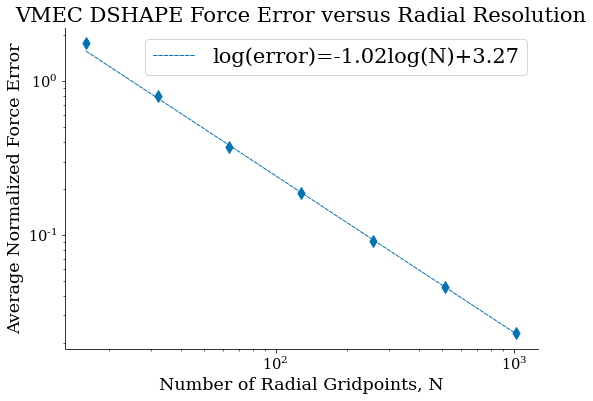

In [19]:

import os
import glob
import numpy as np
import pickle

cwd = os.getcwd()
cwd = cwd + "/VMEC_outputs/ns_sweep"


def get_timing_data(timing_file):
    """
    
    Parameters
    ----------
    timing_file : string
        Absolute path to a VMEC timings.txt output file.

    Returns
    -------
    Data: float
        float of total time in seconds the VMEC run took (total time from timings.txt)            

    """
    with open(timing_file) as f:
        lines = f.readlines()
        for line in lines:
            if line.find("total") != -1:
                line = line.split()
                total_time = float(line[-1].strip())
                break
    return total_time


def get_ftol(inputfile):
    with open(inputfile, "r") as fff:
        lines = fff.readlines()
        for line in lines:
            if line.find("FTOL_ARRAY") != -1:
                ftols = line.split("=")[1].split()
                ftol = ftols[-1]
    return ftol


def get_f_err(dirname):
    # Fpath = os.path.join(dirname,'F_spline_full_vol_normalized_vol_weighted_correctly_with_erho_01s.txt')
    # Fpath = os.path.join(dirname,'F_spline_full_vol_normalized_vol_weighted_correctly_with_erho_005s_ftol12.txt')
    Fpath = os.path.join(
        dirname,
        "F_findif_full_vol_normalized_vol_weighted_correctly_with_erho_01s_099s_lam_half_mesh.txt",
    )
    # Fpath = os.path.join(dirname,'F_findif_normalized_01_099s_lam_half_mesh.txt')
    Fpath = os.path.join(dirname, "F_findif_normalized_01_099s_lam_full_mesh_all.txt")
    F = float(np.genfromtxt(Fpath))
    print(F)
    return F


print("M,N,ns, Total Time")


data_dict = {}

for dir in os.walk(cwd):
    files = dir[2]
    timing_file_exists = False
    # print(dir[1])
    for filename in files:
        if (
            filename.find("wout") != -1
        ):  # and filename.find("32GB") != -1): # check if wout is present
            try:
                timing_file_exists = True
                t_path = os.path.join(dir[0], "timings.txt")
                t = get_timing_data(t_path)
                is_32GB = False
                if filename.find("32GB") != -1:
                    is_32GB = True
                filename = filename.strip(".nc").split("_")
                ns = filename[2].strip("s")
                M = filename[3].strip("M")
                N = filename[4].strip("N")

                input_file = glob.glob(dir[0] + "/input*")[0]
                F = get_f_err(dir[0])
                data_dict["s%s_M%s_N%s" % (ns, M, N)] = [t, F]
            except Exception as e:
                print(e)
            break
    if timing_file_exists:
        print(M, N, ns, t)



data = data_dict
from matplotlib import pyplot as plt
import numpy as np

xfontsize = 18
legend = 12
plt.rcParams.update({"figure.figsize": (8, 6)})
plt.rcParams.update({"font.size": 21})
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)


plt.close("all")

msize = 70

MNs = [16]
ftols = [12]
colors = ["k", "b", "r", "g", "c", "tab:orange"]
shapes = ["d", "o", "x", "^"]
# plt.figure()
# cpus=[1]
cpus = [1]
plt.figure(figsize=(8, 6))
ts = [[], [], [], []]
Fs = [[]]
MN_for_colors = [[], [], [], []]
ns = [16, 32, 64, 128, 256, 512, 1024]
for k, MN in enumerate(MNs):

    for j, ftol in enumerate(ftols):

        for i, s in enumerate(ns):
            runname = "s%s_M%s_N0" % (s, MN)
            print(runname)
            try:
                t, F = data[runname]

                Fs[k].append(F)

            except:
                print("VMEC run with params %s does not exist" % runname)
    print(Fs)
cm = plt.cm.get_cmap("plasma")
for i in range(len(Fs)):
    plt.scatter(ns, np.asarray(Fs[i]), marker="d", s=msize)
plt.legend()
plt.xlabel("Number of Radial Gridpoints, N")
plt.ylabel("Average Normalized Force Error")
plt.title("VMEC DSHAPE Force Error versus Radial Resolution")
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
# plt.xlim([3.5e-1,6e4])
import scipy.stats

for i in range(len(Fs)):
    x = np.log(ns)[1:]
    y = np.log(Fs[i])[1:]
    fit = scipy.stats.linregress(x=x, y=y)
    slope = fit.slope
    print(f"M={MNs[i]}, slope = {slope}")
    plt.plot(
        ns,
        np.asarray(ns) ** slope * np.exp(fit.intercept),
        "--",
        label=f"log(error)={slope:1.2f}log(N)+{fit.intercept:1.2f}",
    )

plt.legend()

plt.savefig("Figures/VMEC_DSHAPE_Radial_Conv.pdf", bbox_inches="tight", pad_inches=0.1)


# Plot F vs ftol scan VMEC (Figure 15)

/tmp/ipykernel_787/2598228681.py:59: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(MN_for_colors[i],np.asarray(Fs[i]),c=fts[i],marker=shapes[i],cmap=cm,label='VMEC NS=%d'%ns[i],s=msize,edgecolor='k',norm=matcolors.LogNorm(vmin=min(fts[0]),vmax=max(fts[0])))


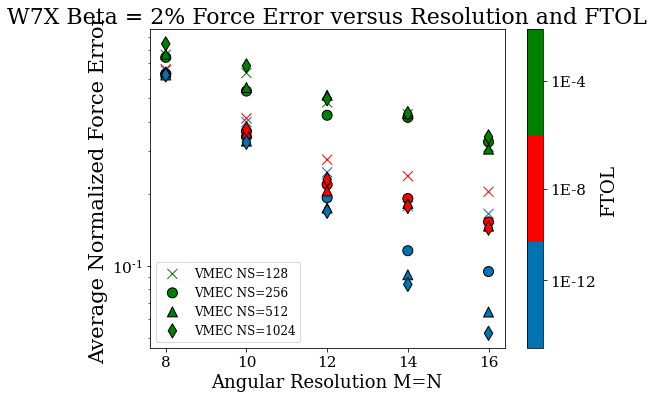

In [20]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
plt.close('all')
with open('VMEC_outputs/W7X_timing_F_findif_normalized_01_099s_lam_full_mesh.txt.p','rb') as f:
    data=pickle.load(f)

with open('DESC_outputs/DESC_W7X_pressure_F_times_normalized_volume_avg_compute_branch.p','rb') as ff:
    desc_data = pickle.load(ff)

desc_patterns = ['fringe','ansi']
msize=100 # marker size

plt.rcParams.update({'font.size': 18})
xfontsize=18
legend=12
plt.rcParams.update({'figure.figsize': (8,6)})
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(8, 6))
colors = ['k','b','r','g']
shapes = ['x','o','^','d']
MNs = [8,10,12,14,16]
ftols = [4,8,12]
cpus=[1]
ns=[128,256,512,1024]
import matplotlib.colors as matcolors
for fi,cpu in enumerate(cpus):
    ns0=False
    ns1 = False
    ns2 = False
    ns3 = False
    ts = [[],[],[],[]]
    Fs = [[],[],[],[]]
    fts = [[],[],[],[]]
    MN_for_colors = [[],[],[],[]]
    
    for MN in MNs:

        for j,ftol in enumerate(ftols):
            
            for i,s in enumerate(ns):
                runname = 's%s_M%s_N%s_f%s_cpu%s'%(s,MN,MN,ftol,cpu)
                try:
                    t,F = data[runname]

                    ts[i].append(t)
                    fts[i].append(1*10**(-ftol))
                    Fs[i].append(F)
                    MN_for_colors[i].append(MN)

                except:
                    print('VMEC run with params %s does not exist'%runname)
    #cm = plt.cm.get_cmap('rainbow')#,np.max(ftols)-np.min(ftols)+1)
    cm = matcolors.ListedColormap(['C0','r','g'],N=3)

    for i in range(len(Fs)):
        plt.scatter(MN_for_colors[i],np.asarray(Fs[i]),c=fts[i],marker=shapes[i],cmap=cm,label='VMEC NS=%d'%ns[i],s=msize,edgecolor='k',norm=matcolors.LogNorm(vmin=min(fts[0]),vmax=max(fts[0])))
    cbar=plt.colorbar(label='FTOL',ticks=[1E-4,1E-8,1E-12])
    cbar.set_ticks([5E-6,1E-8,5E-11])
    cbar.set_ticklabels(['1E-4','1E-8','1E-12'])
    cbar.minorticks_off()
    plt.legend(fontsize=12,loc='lower left')
    plt.xlabel('Angular Resolution M=N',fontsize=xfontsize)
    plt.ylabel('Average Normalized Force Error',fontsize=21)
    plt.title('W7X Beta = 2'+'%'+' Force Error versus Resolution and FTOL')
    ax=plt.gca()
    ax.set_yscale('log')
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
plt.savefig('Figures/W7X_beta_VMEC_res_ftol_comp.pdf', bbox_inches='tight',pad_inches = 0.1)



# Plot profiles and flux surfaces W7-X and DSHAPE (Figures 16,17,18,19)

In [21]:
from desc.equilibrium import EquilibriaFamily
from desc.vmec import VMECIO
import matplotlib.pyplot as plt


In [22]:
eq = EquilibriaFamily.load(load_from='DESC_outputs/W7X_M16_N16_ansi_cpu8_output_new_DESC.h5')[-1]

/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_surface' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_axis' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_spacing' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_brmask' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_bzmask' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_rmask' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_zmask' was not loaded.
  warnings.warn(


In [23]:
from desc.plotting import plot_1d

In [24]:
%matplotlib inline
from desc.grid import LinearGrid
grid = LinearGrid(L=5*eq.L_grid)
p = eq.compute('p',grid=grid)
i = eq.compute('iota',grid=grid)

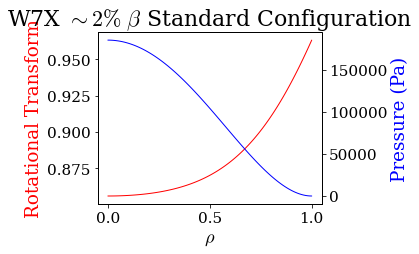

In [25]:
import numpy as np
plt.rcParams.update({'font.size':22})
fig,ax = plt.subplots()
rho = np.unique(grid.nodes[:,0])
ax2 = ax.twinx()
ax2.plot(rho,p['p'],'b',label='p')
ax.plot(rho,i['iota'],'r',label='iota')
ax2.set_ylabel('Pressure (Pa)',c='b')
ax.set_ylabel('Rotational Transform',c='r')
ax.set_xlabel(r'$\rho$')
ax.set_title(r'W7X $\sim 2\%~\beta$ Standard Configuration')
ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth('1')  
plt.tight_layout()
plt.savefig('Figures/W7X_beta_profiles.pdf')

In [26]:
print('Pressure Profile Coefficients')
for coeff,l in zip(eq.p_l,eq.pressure.basis.modes):
    print(f'l = {l[0]}, coeff = {coeff} ')

Pressure Profile Coefficients
l = 0.0, coeff = 185596.929 
l = 1.0, coeff = 0.0 
l = 2.0, coeff = -371193.859 
l = 3.0, coeff = 0.0 
l = 4.0, coeff = 185596.929 
l = 5.0, coeff = 0.0 
l = 6.0, coeff = 0.0 
l = 7.0, coeff = 0.0 
l = 8.0, coeff = 0.0 


In [27]:
print('Rotational Transform Profile Coefficients')
for coeff,l in zip(eq.i_l,eq.iota.basis.modes):
    print(f'l = {l[0]}, coeff = {coeff} ')

Rotational Transform Profile Coefficients
l = 0.0, coeff = 0.856047021 
l = 1.0, coeff = 0.0 
l = 2.0, coeff = 0.0388095412 
l = 3.0, coeff = 0.0 
l = 4.0, coeff = 0.0686795128 
l = 5.0, coeff = 0.0 
l = 6.0, coeff = 0.0186970315 
l = 7.0, coeff = 0.0 
l = 8.0, coeff = -0.0190561179 


6


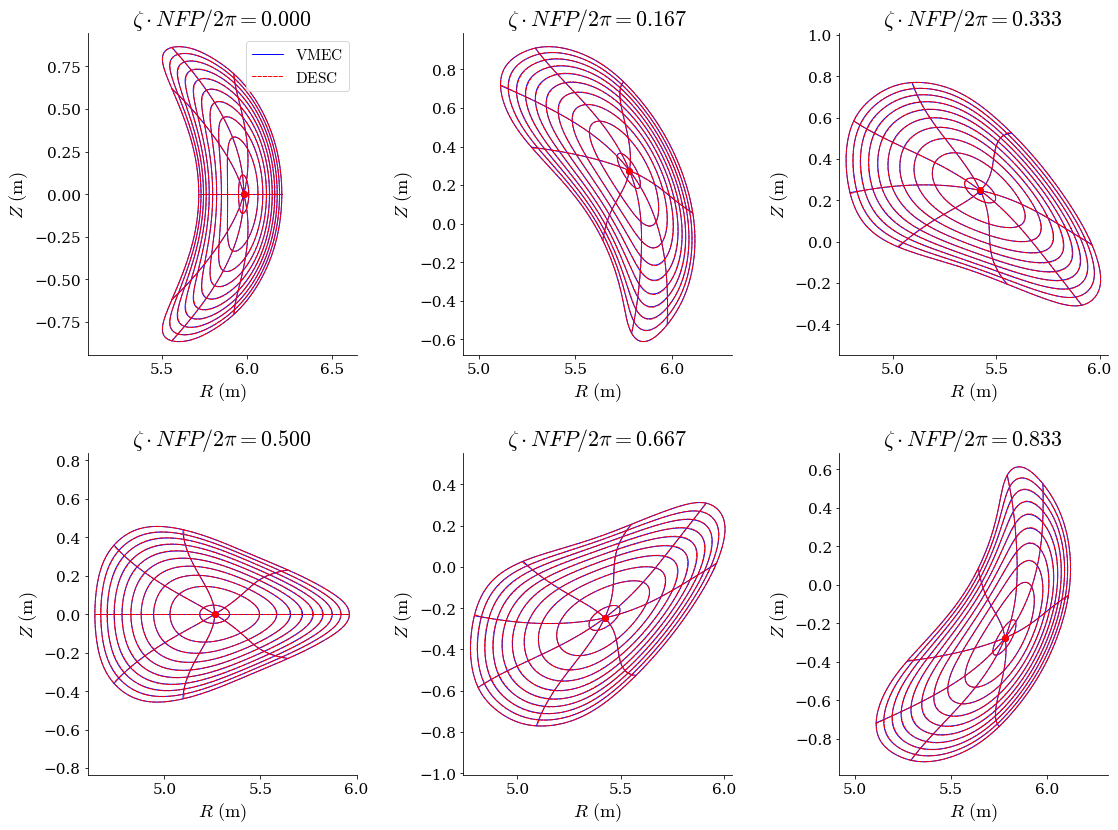

In [28]:
# make flux surface comparison plot
vmecfile = 'VMEC_outputs/wout_W7X_s512_M16_N16_f12_cpu1.nc'
fig,ax=VMECIO.plot_vmec_comparison(equil=eq,vmec_data=vmecfile)
print(len(ax))
for i in range(len(ax)):
    ax[i].set_title(r'$\zeta \cdot NFP / 2\pi = %0.3f$'%(i/6))
plt.tight_layout()
plt.savefig('Figures/W7X_beta_surfaces.pdf')

In [29]:
eqD = EquilibriaFamily.load(load_from='DESC_outputs/DSHAPE_quad_M14_small_pert_master_output.h5')[-1]

/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_spacing' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_L' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_M' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_N' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_R_lmn' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_Z_lmn' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute 'shift' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute 'rotmat' was not loaded.
  warnings.warn(
/home/dpanici/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_NFP' wa

In [30]:
grid = LinearGrid(L=5*eq.L_grid)
p = eqD.compute('p',grid=grid)
i = eqD.compute('iota',grid=grid)

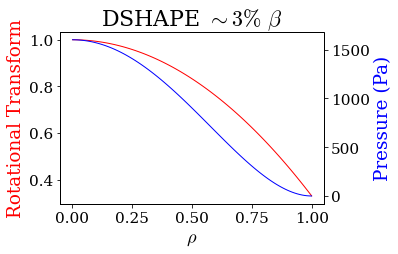

In [31]:
# Plot profiles
import numpy as np

plt.rcParams.update({'font.size':22})
fig,ax = plt.subplots()
rho = np.unique(grid.nodes[:,0])
ax2 = ax.twinx()
ax2.plot(rho,p['p'],'b',label='p')
ax.plot(rho,i['iota'],'r',label='iota')
ax2.set_ylabel('Pressure (Pa)',c='b')
ax.set_ylabel('Rotational Transform',c='r')
ax.set_xlabel(r'$\rho$')
ax.set_title(r'DSHAPE $\sim 3\%~\beta$')
ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth('1')  
plt.tight_layout()
plt.savefig('Figures/DSHAPE_beta_profiles.pdf')

In [32]:
print('Pressure Profile Coefficients')
for coeff,l in zip(eqD.p_l,eqD.pressure.basis.modes):
    print(f'l = {l[0]}, coeff = {coeff} ')

Pressure Profile Coefficients
l = 0.0, coeff = 1600.0 
l = 1.0, coeff = 0.0 
l = 2.0, coeff = -3200.0 
l = 3.0, coeff = 0.0 
l = 4.0, coeff = 1600.0 


In [33]:
print('Rotational Transform Profile Coefficients')
for coeff,l in zip(eqD.i_l,eqD.iota.basis.modes):
    print(f'l = {l[0]}, coeff = {coeff} ')

Rotational Transform Profile Coefficients
l = 0.0, coeff = 1.0 
l = 1.0, coeff = 0.0 
l = 2.0, coeff = -0.67 
l = 3.0, coeff = 0.0 
l = 4.0, coeff = 0.0 


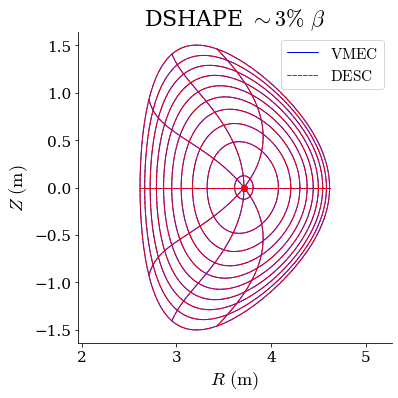

In [34]:
# make flux surface comparison plot
vmecfile_D = 'VMEC_outputs/wout_DSHAPE_s128_M14.nc'
VMECIO.plot_vmec_comparison(equil=eqD,vmec_data=vmecfile_D)
plt.title(r'DSHAPE $\sim 3\%~\beta$')
plt.tight_layout()
plt.savefig('Figures/DSHAPE_beta_surfaces.pdf')